Wczytanie bibliotek

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Wczytanie danych

In [2]:
# Code mostly from: https://archive.ics.uci.edu/dataset/23/chess%2Bking%2Brook%2Bvs%2Bking
# fetch dataset 
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
  
# data (as pandas dataframes) 
df = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 
df["white-depth-of-win"] = y

Obróbka danych:
- zamiania liter na liczby
- dodanie metryk
- dodanie odległości króla od brzegy planszy

In [3]:
### Oznaczenia

kolumny = ["white-king-file", "white-rook-file","black-king-file"]
ozn = {"a":1,"b":2,"c":3,"d":4,"e":5,"f":6,"g":7,"h":8}
df[kolumny]=df[kolumny].replace(ozn)

l_ruch = dict(zip(df["white-depth-of-win"].unique(),[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]))
df["white-depth-of-win"] = df["white-depth-of-win"].replace(l_ruch)

### Metryki

df["euklides"] = np.sqrt(np.square(df.loc[:,"white-king-file"]-df.loc[:,"black-king-file"])+
                  np.square(df.loc[:, "white-king-rank"]-df.loc[:,"black-king-rank"]))

df["manhattan"] = (np.abs(df.loc[:,"white-king-file"]-df.loc[:,"black-king-file"])+
                   np.abs(df.loc[:, "white-king-rank"]-df.loc[:,"black-king-rank"]))

df["czebyszew"] = np.maximum(np.abs(df.loc[:,"white-king-file"]-df.loc[:,"black-king-file"]),
                         np.abs(df.loc[:, "white-king-rank"]-df.loc[:,"black-king-rank"]))

### Odległość od najbliższej krawędzi planszy

df["dist_plansza"]=np.minimum(np.minimum(8-df.loc[:,"black-king-rank"],df.loc[:,"black-king-rank"]-1),
 np.minimum(8-df.loc[:,"black-king-file"],df.loc[:,"black-king-file"]-1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16840\2919823609.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[kolumny]=df[kolumny].replace(ozn)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16840\2919823609.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["white-depth-of-win"] = df["white-depth-of-win"].replace(l_ruch)


# Zadanie 1, dane:

In [4]:
df_remis = df.loc[(df["white-depth-of-win"]==-1),["black-king-file","black-king-rank"]]
tabela_remis=pd.crosstab(df_remis["black-king-rank"],df_remis["black-king-file"])
tabela_remis = tabela_remis[::-1]

full_index = pd.MultiIndex.from_product([range(1,9), range(1,9)], names=["x", "y"])

df_mat=(df.loc[(df["white-depth-of-win"]==0),["black-king-file","black-king-rank"]].groupby(
   ["black-king-file","black-king-rank"]).size().to_frame("count").reset_index().
   rename(columns={"black-king-file":"x","black-king-rank":"y"}))

df_mat = (df_mat.set_index(["x", "y"]).reindex(full_index)
          .reset_index().fillna(0)
          ).pivot(index="y",columns="x",values="count")
df_mat=df_mat[::-1]

# Wykresy zadanie 1

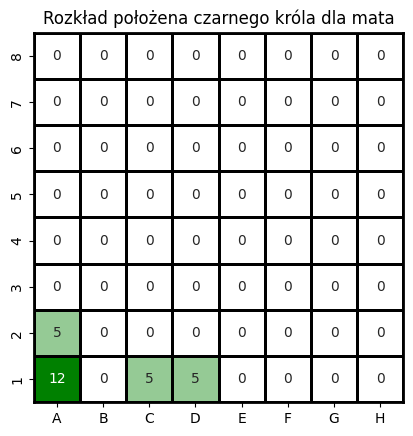

In [5]:
### Zadanie 1, wykres dla mata
kolory = ["#ffffff", "#008000"]
gradient = LinearSegmentedColormap.from_list("grad", kolory)

plot1_mat=sns.heatmap(df_mat,annot=True, linecolor="black",linewidths=0.8, square=True, cmap=gradient,
            xticklabels=["A","B","C","D",'E','F','G','H'],cbar=False,
            vmin=0,vmax=12,center=6)
plt.title("Rozkład położena czarnego króla dla mata")
plt.xlabel("")
plt.ylabel("")

osie=["bottom","left","right","top"]
for i in osie:
    plot1_mat.spines[i].set_visible(True)
    plot1_mat.spines[i].set_linewidth(2)

# Interpretacja
Zgodnie z danymi czarny król w przypadku mata zajduje się najczęściej w rogu planszy lub przy krawędzi planszy blisko rogu. Nie ma przypadków, by król znalazł się bliżej środka, co zgadza się z teorią szachów.

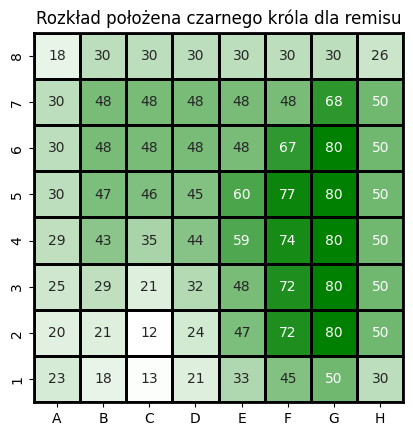

In [6]:
### Zadanie 1, wykres dla remisu
plot1_remis=sns.heatmap(tabela_remis,annot=True, linecolor="black",linewidths=0.8, square=True, cmap=gradient,
            xticklabels=["A","B","C","D",'E','F','G','H'],cbar=False)
plt.title("Rozkład położena czarnego króla dla remisu")
plt.xlabel("")
plt.ylabel("")

osie=["bottom","left","right","top"]
for i in osie:
    plot1_remis.spines[i].set_visible(True)
    plot1_remis.spines[i].set_linewidth(2)

# Interpretacja

W przypadku remisu czarny król znajduję się raczej po prawej części planszy, ale co ważnie nie przy samej krawędzi, tylka raczej na linii G lub F. Rzadka są pola C1, C2, C3, podobne wartości w rogach są niskie. 

# Zadanie 2

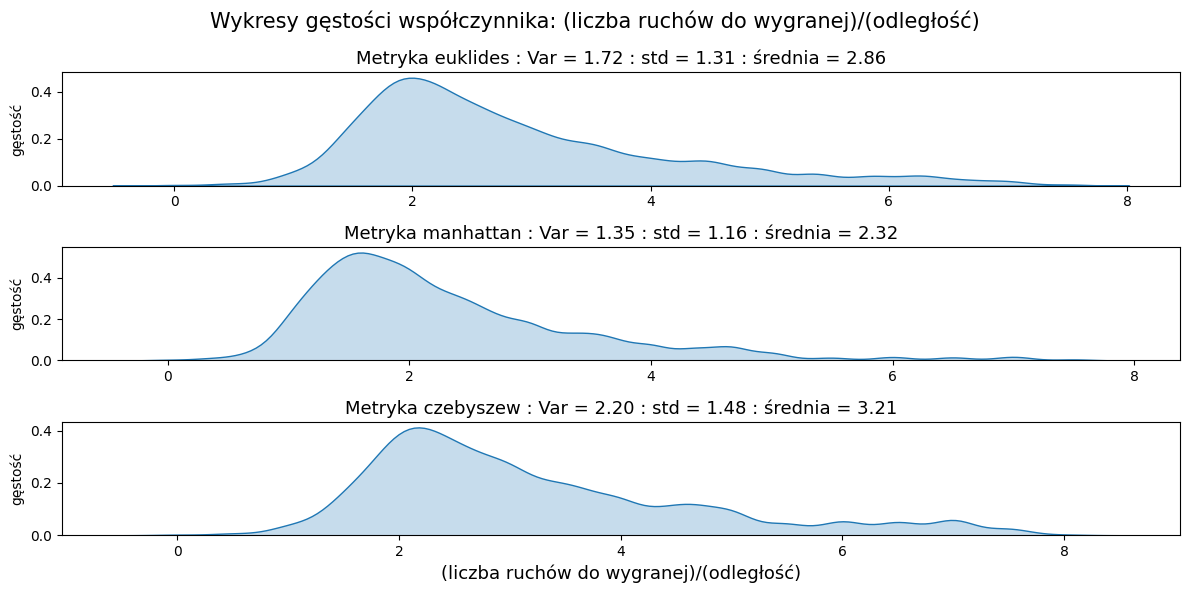

In [7]:
df2 = df[df["white-depth-of-win"]!=-1].copy()


metryki=["euklides","manhattan","czebyszew"]
wsp = ["wsp_euk","wsp_man","wsp_czeb"]
y="white-depth-of-win"

df2.loc[:,"wsp_euk"]=df2[y]/df2[metryki[0]]
df2.loc[:,"wsp_man"]=df2[y]/df2[metryki[1]]
df2.loc[:,"wsp_czeb"]=df2[y]/df2[metryki[2]]


fig2, ax2 = plt.subplots(3,1,figsize=(12,6))
ax2 = ax2.flatten()

for i in range(len(ax2)):
    sns.kdeplot(df2[wsp[i]],fill=True, ax=ax2[i])
    std=df2[wsp[i]].std()
    var=df2[wsp[i]].var()
    mean=df2[wsp[i]].mean()
    ax2[i].set_title("Metryka "+metryki[i]+
                     f" : Var = {var:.2f} : std = {std:.2f} : średnia = {mean:.2f}", 
                     fontsize=13)
    ax2[i].set_xlabel("")
    ax2[i].set_ylabel("gęstość")

wariancja=(df2[y]/df2[metryki[i]]).var()
std = (df2[y]/df2[metryki[i]]).std()

plt.suptitle("Wykresy gęstości współczynnika: (liczba ruchów do wygranej)/(odległość)",
             fontsize=15)
plt.xlabel("(liczba ruchów do wygranej)/(odległość)", fontsize=13)
plt.tight_layout()

# Interpretacja

Policzyliśmy współczynnik: (liczba ruchów do wygranej)/(odległość). Dla metryki Manhattan rozkład ma najmniejszą wariancję, czyli jeśli znamy odległość dla jakiegoś nowego ruchu to dla tej metryki po przemnożeniu przez średnią będziemy statystycznie najbliżej oczekiwanej liczby ruchów do wygranej. Pozostałe rozkłady są mniej zbite - mają większą wariancję.

# Zadanie 3

Wykres rozkładu ilości ruchów do zwycięstwa w zależności od odległości czarnego króla od brzegu planszy

Text(0, 0.5, 'Ilość ruchów do wygranej')

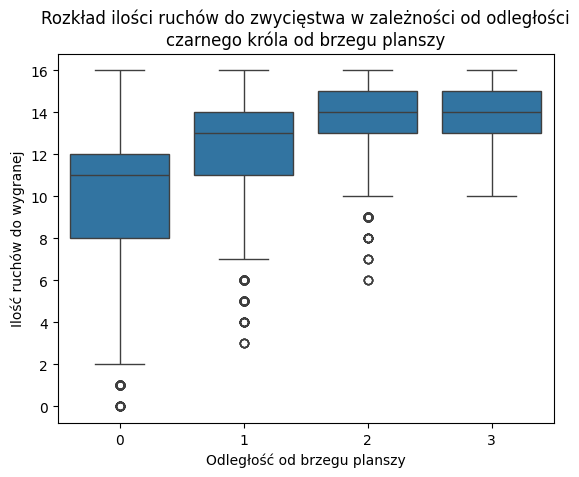

In [19]:
sns.boxplot(df2, x="dist_plansza",y=y)
plt.title("Rozkład ilości ruchów do zwycięstwa w zależności od odległości\n" \
"czarnego króla od brzegu planszy")
plt.xlabel("Odległość od brzegu planszy")
plt.ylabel("Ilość ruchów do wygranej")

# Interpretacja

Złożenie ze sobą tych dwóch paramterów nie daje dużo. Można odczytać, że jeśli król jest oddalony od brzegu planszy o 2 lub 3 pola to sekwencja zwycięstwa ma raczej dużo ruchów. Dla odległości 1 spodziewamy się też dłuższej sekwencji, ale mogą się pojawić wyjątki. Jeśli król jest brzegu planszy to nie możemy stwierdzić, czy wygrana będzie szybko, czy późno, chociaż ponad połowa wyników wskazuje na sekwencję ponad 10 ruchów.

Do dokładniejszej analizy wykorzystamy wybraną w poprzednim zadania metrykę Manhattan

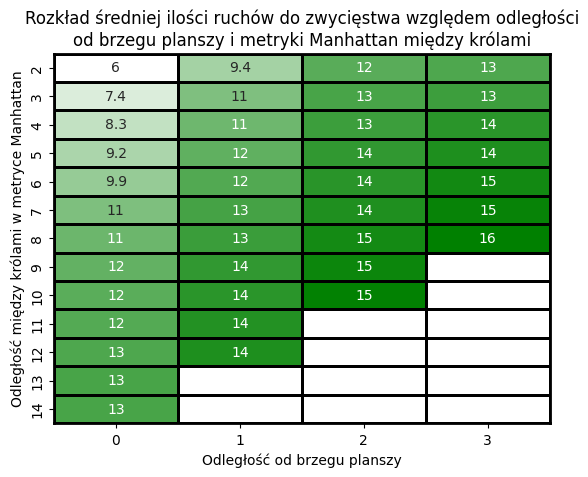

In [18]:
df3 =df2.loc[:,["manhattan","dist_plansza","white-depth-of-win"]].groupby(["manhattan","dist_plansza"]).agg("mean").reset_index()
df3=df3.pivot(index="manhattan",columns="dist_plansza",values="white-depth-of-win")


plot3=sns.heatmap(df3,annot=True, linecolor="black",linewidths=0.8, cmap=gradient,
            cbar=False)
plt.title("Rozkład średniej ilości ruchów do zwycięstwa względem odległości\n" \
"od brzegu planszy i metryki Manhattan między królami")
plt.xlabel("Odległość od brzegu planszy")
plt.ylabel("Odległość między królami w metryce Manhattan")

osie=["bottom","left","right","top"]
for i in osie:
    plot3.spines[i].set_visible(True)
    plot3.spines[i].set_linewidth(2)

# Interpretacja

Jak widać, jeśli króle są blisko siebie i blisko brzegu planszy to średnio gra zakończy się dosyć szybko. Im dalej są króle od siebie i im dalej jest król od brzegu plansz to sekwencja zwycięstwa jest średnio dłuższa, z tym, że efekt odległości króla od brzegu plansyz jest trochę silniejszy (w prawą stronę barwy szybciej ciemnieją niż w dół).

Pozycje z niezerową odległoścą od brzegu planszy wykluczają istnienie niektórych odległości z metryki Manhattana, co widać przez białe pola.